# Experimenting with transformers
Transformers remain as a promising replacement of RNNs due to their parallelizability. However, RNNs are unique in their hidden state which tends to be uniquely useful for games. 



In [19]:
import pickle
import torch
import pandas as pd
import importlib
import numpy as np
import utils
import models

importlib.reload(utils)
from utils import *
importlib.reload(models)
from models import *

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [ ]:
grouped_df = pd.read_csv('../data/haha-longer-longer-001.csv')

In [20]:
# Function to load a memmap file
def load_memmap(filename, dtype, shape):
    # Load the memmap file with read-only mode
    return np.memmap(filename, dtype=dtype, mode='r', shape=shape)

In [21]:
# For trainX
dtype_trainX = np.int32  # or the correct dtype for your data
shape_trainX = (2161482, 750)  # replace with the correct shape
trainX = load_memmap('./../data/transformer/jan/trainX.memmap', dtype_trainX, shape_trainX)

# For trainY
dtype_trainY = np.int32 # or the correct dtype for your data
shape_trainY = (2161482, 7)  # replace with the correct shape
trainY = load_memmap('./../data/transformer/jan/trainY.memmap', dtype_trainY, shape_trainY)

with open('./../data/transformer/jan/vocab.pkl', 'rb') as inp:
    vocab = pickle.load(inp)

In [4]:
print(trainX[:1,:4])  

[[1 0 2 0]]


In [6]:

class TransformerDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences, self.labels = sequences, labels
        
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [7]:
dataset = TransformerDataset(trainX, trainY)
total_size = len(dataset)
# We're scaling the model size so let's bring in more data as well
train_size = int(0.98 * total_size)
val_size = int(total_size * 0.02)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)
# Reload the data with particular batch size
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


2118252


In [18]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

class ChessTransformer(nn.Module):
    def __init__(self, vocab, d_model, nhead, num_layers, max_seq_length=750, dropout=0.1):
        super(ChessTransformer, self).__init__()
        self.vocab = vocab
        self.vocab_size = len(vocab.id_to_word.keys())
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_seq_length)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers,
                                          batch_first=True)
        self.fc = nn.Linear(d_model, self.vocab_size)
        self.max_seq_length = max_seq_length

    def forward(self, src, tgt):
        # Create source padding mask
        print(src.shape)
        src_padding_mask = self.create_padding_mask(src).to(src.device)
        tgt_padding_mask = self.create_padding_mask(tgt).to(tgt.device)
        # Embedding and Positional Encoding for src

        src_emb = self.embedding(src)  # [batch_size, seq_len] -> [batch_size, seq_len, d_model]
        src_emb = self.pos_encoder(src_emb)
        print(src_emb.shape)
        # Assuming tgt is provided correctly and also needs embedding & positional encoding
        tgt_emb = self.embedding(tgt)
        tgt_emb = self.pos_encoder(tgt_emb)

        # Transformer
        output = self.transformer(src_emb, tgt_emb, src_key_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask)
        print(output.shape)
        # Linear layer to predict vocab
        output = self.fc(output)
        print(output.shape)
        return output
    
    def create_padding_mask(self, src):
        PAD_IDX = 0
        src_padding_mask = (src == PAD_IDX)
        return src_padding_mask
    
    def generate_sequence(self, src, src_length, start_symbol_id, sep_token_id, max_length=100):
        """
        Generate a sequence autoregressively using the trained transformer model.

        Args:
        - src (Tensor): The input source sequence tensor.
        - src_length (Tensor): The length of the source sequence.
        - start_symbol_id (int): The ID of the start symbol to begin generation.
        - sep_token_id (int): The ID of the SEP token for sequence termination.
        - max_length (int): Maximum length of the generated sequence to prevent infinite loops.

        Returns:
        - The generated sequence tensor.
        """
        self.eval()  # Ensure the model is in eval mode

        # Initialize the target sequence with the start symbol
        tgt = torch.tensor([start_symbol_id], dtype=torch.long).to(src.device)
        
        for _ in range(max_length):
            # Assuming src_length is a tensor with the length of src. Adjust as needed.

            # Perform a forward pass to get logits for the next token
            logits = self.forward(src, src_length, tgt, src)
            # Get the last token logits and apply softmax to get probabilities
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            # get most likely token from probs
            next_token = torch.max(probs, 1)
            
            # Append the predicted token to the target sequence
            tgt = torch.cat((tgt, next_token), dim=1)
            
            # Check if the <SEP> token is generated
            if next_token.item() == sep_token_id:
                break

        return tgt


Functions for training

In [15]:
# Function to calculate top-3 accuracy
def top_3_accuracy(y_true, y_pred):
    top3 = torch.topk(y_pred, 3, dim=1).indices
    correct = top3.eq(y_true.view(-1, 1).expand_as(top3))
    return correct.any(dim=1).float().mean().item()

def train_transformer(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, learn_decay):
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    val_3_accuracy = []
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        training_loss = 0.0
        # Training
        model.train()
        count = 0
        for sequences, labels in train_loader:
            count += 1
            sequences, lengths, labels = sequences.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            # Forward Pass
            logits = model(sequences, labels)
            print(logits)
            loss = criterion(logits.view(-1, model.vocab_size), labels.contiguous().view(-1))
            # Backpropogate & Optimize
            optimizer.zero_grad()
            loss.backward()
            # Clip it
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            # For logging purposes
            training_loss += loss.item()
            # _, predicted = torch.max(output.data, 1)
            # train_total += labels.size(0)
            # train_correct += (predicted == labels).sum().item()
            # Get the predicted class indices for each position in each sequence
            _, predicted = torch.max(logits.data, dim=2)  # Shape: (batch_size, seq_length)
            correct_predictions = predicted == labels  # Shape: (batch_size, seq_length)
            correct_sequences = correct_predictions.all(dim=1)  # Shape: (batch_size)
            train_correct += correct_sequences.sum().item()
            train_total += labels.size(0) 
            break
            if count % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch: {count}| Training Loss: {training_loss/count}')
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        validation_loss = 0.0
        # if val_loader is not None:
        #     with torch.no_grad():
        #         val_correct = 0
        #         val_total = 0
        #         val_top3_correct = 0
        #         validation_loss = 0

        #         for sequences, lengths, labels in val_loader:
        #             sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
        #             outputs = model.generate(sequences, lengths)
        #             _, predicted = torch.max(outputs.data, 1)
        #             val_total += labels.size(0)
        #             val_correct += (predicted == labels).sum().item()
        #             val_top3_correct += top_3_accuracy(labels, outputs) * labels.size(0)
        #             loss = criterion(outputs, labels)
        #             validation_loss += loss.item()

        #         val_loss_values.append(validation_loss / len(val_loader))
        #         val_accuracy = 100 * val_correct / val_total
        #         val_top3_accuracy = 100 * val_top3_correct / val_total
        #         val_error.append(100 - val_accuracy)
        #         val_3_accuracy.append(val_top3_accuracy)
        # Log Model Performance  
        train_loss_values.append(training_loss)
        train_error.append(100-100*train_correct/train_total)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss/len(train_loader)}, Validation Error: {val_error[-1]}, Validation Top-3 Accuracy: {val_3_accuracy[-1]}, Training Error: {train_error[-1]}')
        for op_params in optimizer.param_groups:
            op_params['lr'] = op_params['lr'] * learn_decay
    return train_error,train_loss_values, val_error, val_loss_values

# Experiments

Experiment 1

In [19]:
# Reload the data with particular batch size
torch.multiprocessing.set_start_method('fork', force=True)
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)

# Initialize model, loss function, and optimizer
d_model = 256
NUM_EPOCHS = 5
vocab_size = len(vocab.id_to_word.keys())
nhead = 8
num_layers = 2
model = ChessTransformer(vocab, d_model, nhead, num_layers = num_layers)
model = model.to(device)
# This ignores loss on pad tokens from the label's perspective
criterion = nn.CrossEntropyLoss(ignore_index=vocab.get_id('<PAD>'))  # Assuming you have a PAD token
lr = 2e-3
weight_decay=1e-7
learn_decay = 0.65 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

5811244


torch.Size([1, 750])
torch.Size([1, 750, 256])
torch.Size([1, 7, 256])
torch.Size([1, 7, 44])
tensor([[[ 0.4648,  0.2252, -0.7298, -0.1633,  0.1543,  0.7997,  0.7714,
          -0.3767, -0.0298, -0.1123,  0.3134, -0.0044,  0.8669,  0.6347,
          -0.2052,  0.3185, -1.3403,  0.0363, -0.2123,  0.6981,  0.7101,
           0.1066,  1.0624, -1.5129, -0.2120,  0.1658,  0.4270, -0.1416,
           0.2197, -0.2524,  0.2754,  0.1417,  0.6042, -0.4900,  0.1448,
          -0.7046, -0.7374,  0.0967, -0.7628,  0.1386,  0.0323, -0.9926,
          -0.0522,  0.8933],
         [-0.3992, -0.0509, -0.0180,  0.1279,  0.3200,  0.0432,  0.5092,
           0.0205,  0.1142, -0.1747,  0.2441, -0.0703, -0.2902,  0.7650,
          -0.1831, -0.4725, -1.2954, -0.6571, -1.0736,  0.2546,  0.3756,
           0.2168,  0.9371, -0.7129,  0.6834, -0.1957,  0.1172, -0.2603,
           0.0576,  0.3933,  0.1552, -0.0979,  1.2780, -0.7649,  0.0508,
          -0.7701, -0.4351, -0.1240, -0.7158,  0.5540, -0.1512, -0.8305,
 

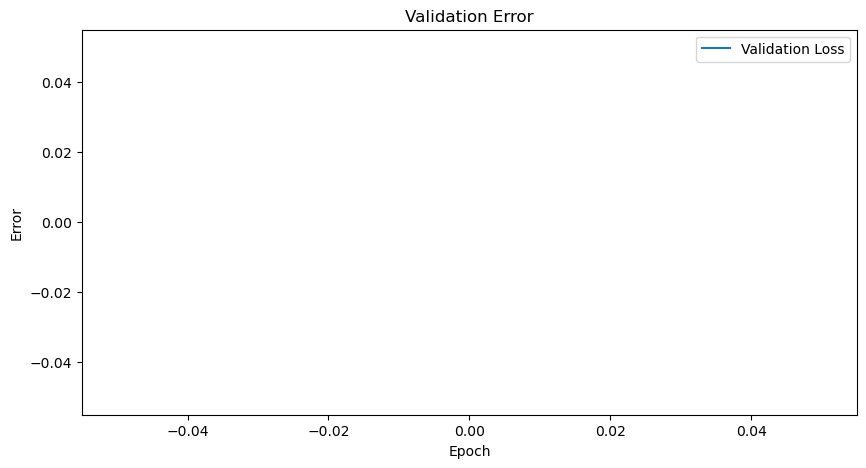

<Figure size 640x480 with 0 Axes>

In [20]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value = train_transformer(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('transformer-4-04.png')  # This will save the plot as an image